In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
mydatabid=pd.read_csv("~/myDB/bidEUR.csv")
mydataask=pd.read_csv("~/myDB/askEUR.csv")
mydatabid=mydatabid[['date','close']]
mydataask=mydataask[['date','close']]
mydatabid=mydatabid.set_index(['date'])
mydataask=mydataask.set_index(['date'])
mydataall=mydatabid.join(mydataask,rsuffix='ASK')
mydataall.columns=['BID','ASK']
mydataall=mydataall.iloc[30000:,:]
mydataall['MID']=(mydataall["BID"]+mydataall["ASK"])/2
plt.plot(mydataall['MID'].values)

FileNotFoundError: File b'/home/user/myDB/bidEUR.csv' does not exist

In [232]:
def spread_check(bid,ask):
    if ask-bid>0.00001:
        return 0
    else:
        return 1
    
def comission(notional,transaction_rate):
    return notional*transaction_rate*0.2/10000

def profit(notional,entry_rate,exit_rate,long_short):
    return (exit_rate-entry_rate)*notional*long_short


In [249]:
import numpy as np
import matplotlib.pyplot as plt
class Status(object):
    def __init__(self, buf):
        self.f_agile = None
        self.f_stable = None
        self.b_bar = None
        self.mw = [0]
        self.x_prev = None
        self.x_bar = None
        
        self.ucl = None
        self.lcl = None
        
        self.forecast = 0
        
        self._buf = buf
        self._bufi = 0
        
    def mean(self):
        return np.mean(self.mw)

    def append(self, x):
        if len(self.mw) > self._buf:
            self.mw[self._bufi] = x
            self._bufi = (self._bufi + 1) % self._buf
        else:
            self.mw.append(x)    

class FlipFlop(object):
    def __init__(self, l=0.1, u=0.9, buf=200):
        self.l = l
        self.u = u
        self.buf = buf
    
    def continous(self, x, status=None):
        '''
        Implementation of the flip flop filter as described by Minkyong Kim and Brian Noble
        EWMA = Exponential Weighted Moving Average
        buffer = Status information that was returned by the previous call 
        '''
        
        # Initialize status
        if status is None:
            status = Status(self.buf)
        
        # Update agile and stable EWMA
        status.f_agile = self.continous_single_exponential_smoothed(status.f_agile, x, self.u)
        status.f_stable = self.continous_single_exponential_smoothed(status.f_stable, x, self.l)
        
        # Update estimated population mean \bar{x}
        status.x_bar = self.continous_single_exponential_smoothed(status.x_bar, x, 0.5)
        
        # Calculate \bar{MW}
        mw_average = status.mean()
            
        # Update upper and lower control limits 
        # (constants are given by the paper)
        ucl = status.x_bar + 3 * (mw_average / 1.128)
        lcl = status.x_bar - 3 * (mw_average / 1.128)
        status.ucl = ucl
        status.lcl = lcl
        
        # Run flip-flop logic
        if status.forecast >= lcl and status.forecast <= ucl:
            # forecast is within control limits
            forecast = status.forecast
        else:
            # Select forecast that is within control limits
            if status.f_agile >= lcl and status.f_agile <= ucl:
                forecast = status.f_agile
            else:
                forecast = status.f_stable
        
        # Update moving range calculation
        if status.x_prev != None:
            delta = abs(x - status.x_prev)
            status.append(delta)
        
        # Return status and forecast
        status.x_prev = x
        status.forecast = forecast 
        return forecast, status
    
    
    def continous_single_exponential_smoothed(self, f_t, data_t, alpha):
        # Smoothing equation (1)
        # f_t is the forecasted value for f_{t+1}
        if f_t == None: 
            return data_t
        
        f_t = alpha * data_t + (1 - alpha) * f_t
        
        return f_t





def main(data,buff,show=False,l=0.1,u=0.9):
    # Add some random noise
    #demand = np.array(data)
    #rand = np.random.normal(loc=0, scale=scale, size=len(demand))
    demand = data.values
    #demand += rand

    # Run smoother
    s0 = []
    s1 = []
    ua = []
    ul = []
    status = None
    f_t = None
    ff = FlipFlop(buf=buff,l=l,u=u)
    for x in demand:
        forecast, status = ff.continous(float(x), status)
        s0.append(forecast)
        
        ua.append(status.ucl)
        ul.append(status.lcl)

    res=pd.DataFrame()
    res['Signal']=s0
    res['main']=demand
    res['u']=ua
    res['d']=ul
    if show:
        plt.figure(figsize=(15,5))
        plt.plot(res['Signal'].iloc[1000:1500])
        plt.plot(res['main'].iloc[1000:1500])
        plt.plot(res['u'].iloc[1000:1500])
        plt.plot(res['d'].iloc[1000:1500])
    plt.show()
    res.index = data.index
    return res




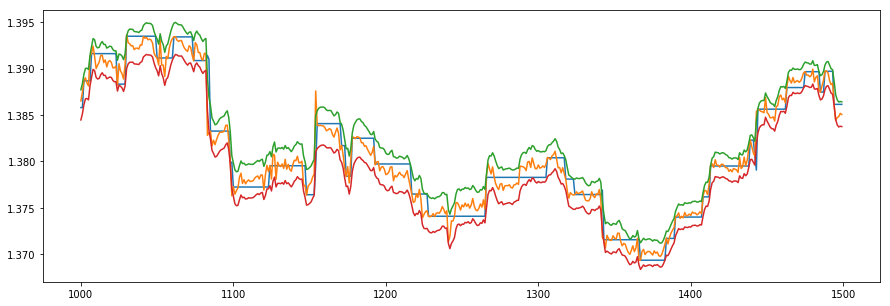

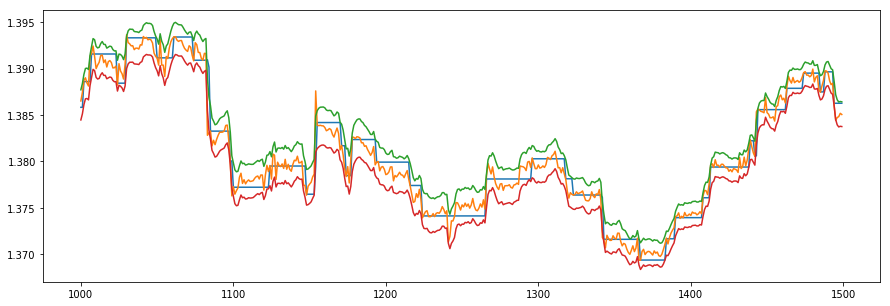

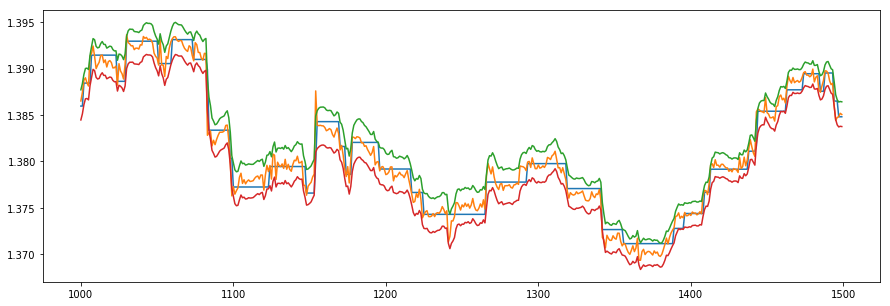

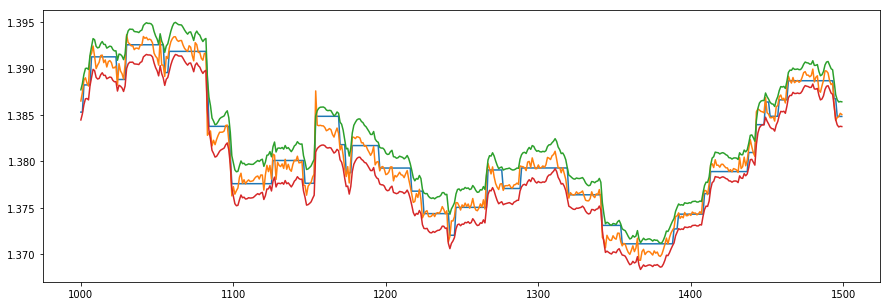

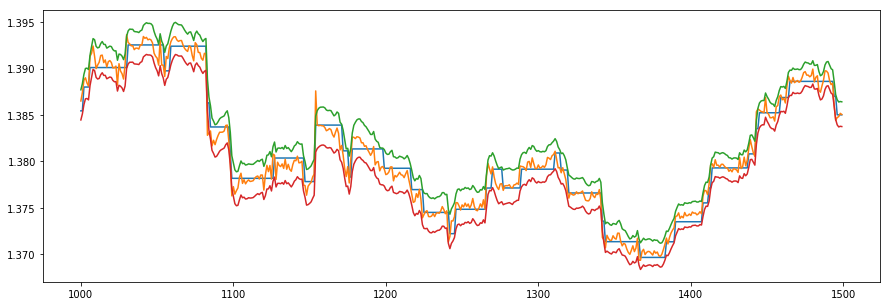

In [254]:
result=(main(mydataall['MID'],200,show=True,l=0.05,u=(1-0.05)))
result=(main(mydataall['MID'],200,show=True,l=0.1,u=(1-0.1)))
result=(main(mydataall['MID'],200,show=True,l=0.2,u=(1-0.2)))
result=(main(mydataall['MID'],200,show=True,l=0.3,u=(1-0.3)))
result=(main(mydataall['MID'],200,show=True,l=0.4,u=(1-0.4)))

In [235]:
diff_list=[]
result=(main(mydataall['MID'],200))
for i in range(1000,len(result)):
    signal=result['Signal'].iloc[i]
    real=result['main'].iloc[i]
    up = result['u'].iloc[i]
    down=result['d'].iloc[i]
    date=result.index[i]
    start=i-1000
    end=i

    data=mydataall["MID"].iloc[0:i+1]
    resultz=(main(data,200))
    sigs=resultz['Signal'].iloc[-1]
    ups = resultz['u'].iloc[-1]
    downs=resultz['d'].iloc[-1]    
    reals=resultz['main'].iloc[-1]  
    diff_list.append(sigs-signal)


KeyboardInterrupt: 

In [265]:


def backtests(seed):
    inpos=0
    pnls=[]
    notional=1000000
    filterlist=[]
    print('init filters')
    for x in range(1,2):
        for y in [0.1]:
            result=(main(mydataall['MID'],200,l=y,u=(1-y)))
        
        filterlist.append(result)
    print('end filters')
    np.random.seed(seed)
    
    
    for i in range(len(mydataall)):
        if i<1000:
            pass
        else:
            
            
            if inpos==0:
                buffer =  np.random.randint(0,len(filterlist))
                
                #for each possible buffer preload the filter
                
                
            rr = filterlist[buffer]

            signal=rr['Signal'].iloc[i]
            up=rr['u'].iloc[i]
            down=rr['d'].iloc[i]
            real=rr['main'].iloc[i]

            
            '''
            signal=result['Signal'].iloc[i]
            real=result['main'].iloc[i]
            up = result['u'].iloc[i]
            down=result['d'].iloc[i]
            '''
            
            bid=mydataall["BID"]
            ask=mydataall["ASK"]
            date=mydataall.index[i]
            dif=up-real
            
            if inpos==0:
                thold=dif*np.random.randint(1,20)/100 
            


            diff=real-signal

            spr=spread_check(bid[i],ask[i])

            
            if inpos==0 and diff>thold and spr==1:
                #short

                entry = bid[i]
                inpos=-1
                comissions=comission(notional,entry)
                com_paid=0
                com_paid+=comissions
                ids=i
               # print('short entry',date)

            elif inpos==0 and diff<-thold and spr==1:

                entry = ask[i]

                inpos=1
                ids=i
                comissions=comission(notional,entry)
                com_paid=0
                com_paid+=comissions
                #print('long entry',date)
            elif inpos==1 and (diff>=thold ):
                exit=bid[i]
                pnl=profit(notional,entry,exit,inpos)
                comissions=comission(notional,exit)
                com_paid+=comissions
                inpos=0
                pnls.append([pnl-com_paid,i-ids,date])

               # print('long exit',date,"-----")
            elif inpos==-1 and (diff<=-thold)  :
                exit=ask[i]
                pnl=profit(notional,entry,exit,inpos)
                inpos=0
                comissions=comission(notional,exit)
                com_paid+=comissions
                pnls.append([pnl-com_paid,i-ids,date])
               # print('short exit',date,"-----")
    print("average profit",np.mean([x[0] for x in pnls]))
    print("average trade period:",np.mean([x[1] for x in pnls]))
    return pnls




init filters
end filters
average profit 124.28134747199286
average trade period: 6.591994382022472
init filters
end filters
average profit 121.19021250886662
average trade period: 6.548840477863668
init filters
end filters
average profit 100.73779018929088
average trade period: 6.562018220042046
init filters
end filters
average profit 113.06656671336775
average trade period: 6.4951048951048955
init filters
end filters
average profit 125.30586208837929
average trade period: 6.5087596355991595
init filters
end filters
average profit 126.483752090798
average trade period: 6.632884479092842
init filters
end filters
average profit 134.54676568221984
average trade period: 6.509142053445851
init filters
end filters
average profit 105.56078731509392
average trade period: 6.556025369978858
init filters
end filters
average profit 140.76066553919554
average trade period: 6.531360112755461


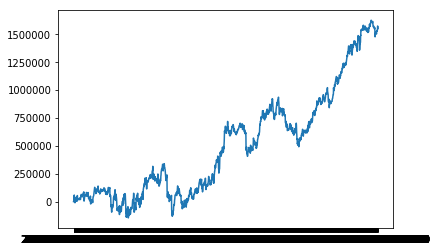

In [266]:
zlist=[]
for x in range(1,10):
    aa=backtests(x)
    pnls=[x[0] for x in aa]
    dates=[x[2] for x in aa]
    z=pd.DataFrame()
    z['pl'+str(x)]=pnls
    z['dd'+str(x)]=dates
    z=z.set_index('dd'+str(x))
    zlist.append(z)
    

resf=pd.DataFrame(index=mydataall.index)

for xx in zlist:
    resf=resf.join(xx)
resf=resf.dropna(axis=0, how='all')
resf=resf.sum(axis=1)
plt.plot(resf.cumsum())
plt.show()

In [13]:
resf.cumsum()

date
2014-03-17 18:00:00    3034.4090
2014-05-06 22:00:00    6458.7062
2014-05-08 18:00:00    8352.9996
dtype: float64

average profit 126.85326204514506
average trade period: 8.17157712305026


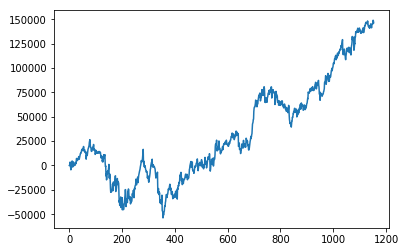

In [407]:
filterlist

In [181]:
a_list=[]
for x in range(10000):
    a=np.random.randint(1,10)
    a_list.append(a)

In [183]:
set(a_list)

    

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [193]:
filterlist

NameError: name 'filterlist' is not defined

In [ ]:
ppp=[]

for x in pnls:
    if x[1]<:
        ppp.append(x[0])
plt.plot(np.cumsum(ppp))

(array([272., 119., 100., 106.,  67., 102.,  45.,  35.,  50.,  23.,  47.,
         33.,  27.,  13.,  27.,  32.,  15.,  15.,   4.,  14.,   7.,   2.,
          4.,   2.,   1.,   7.,   1.,   1.,   1.,   2.,   4.,   2.,   2.,
          1.,   1.,   2.,   1.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ,  14.2,  15.4,  16.6,  17.8,  19. ,  20.2,  21.4,
         22.6,  23.8,  25. ,  26.2,  27.4,  28.6,  29.8,  31. ,  32.2,
         33.4,  34.6,  35.8,  37. ,  38.2,  39.4,  40.6,  41.8,  43. ,
         44.2,  45.4,  46.6,  47.8

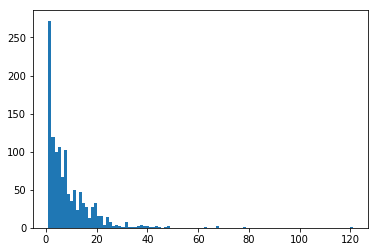

In [ ]:
(1.13521-1.13531)*10000

In [ ]:
real